In [ ]:
!pip install -q "git+https://github.com/DavidLandup0/deepvision"

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install tensorflow==2.11.0
!pip install tensorflow-datasets

In [3]:
!pip install omegaconf albumentations

In [3]:
import sys
sys.path.append('../..')

In [5]:
import deepvision
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K

/home/tuvis/miniconda3/envs/knowsmoke-dev-2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd drive/MyDrive/segformer

/content/drive/MyDrive/segformer


In [7]:
import sys
sys.path.append("tf_seg")

In [8]:
from tf_seg.data import get_data_loader, DataLoader
from tf_seg.losses import DiceLoss
from tf_seg.metrics import DiceScore

In [11]:
data_config = dict(
    name="dross_segmentation",
    function_name="custom",  # it is used camvid dataset to generate binary d#ata
    path="../../altek/data/altek_current/",#"ignis/data/segmentation/data_v2",
    classes=["dross","skimmer","cabin"],#,"skimmer","cabin"],
    normalizing=True,
    palette=[(1,1,1),(2,2,2),(3,3,3)],#,(53, 183, 120)],
    one_hot_encoding=True,  # target output shape
    background_adding=True,  # add target background class
    image_size=(512, 512),
    batch_size=4, #
    output_type=("tf.float32", "tf.float32"),  # this is for camvid data types after data processing
    channels=(3, 3),  # it is optional
)
aug_config = dict(aug_type="albumentations")

In [12]:
train_loader, val_loader = get_data_loader(data_config, True, True, False)

2023-09-21 23:29:47.604023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 23:29:47.659460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 23:29:47.659607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 23:29:47.661243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
train_set = train_loader.load_data()
test_set = val_loader.load_data()

In [13]:
for i in train_set:
  print(i[0].shape, i[1].shape)
  print(i[1])
  break

(4, 512, 512, 3) (4, 512, 512, 4)
tf.Tensor(
[[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  ...

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]


 [[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...


In [ ]:
import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(8, 4))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

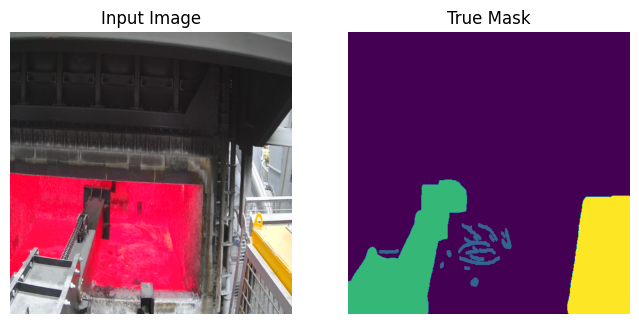

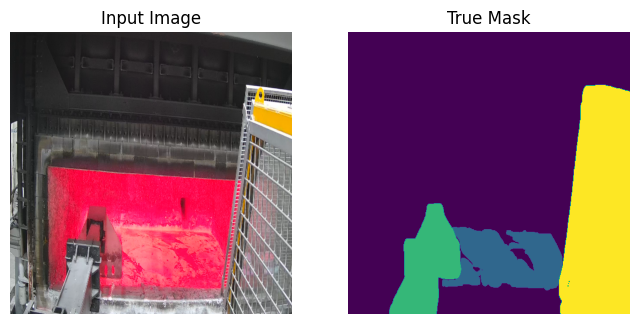

In [ ]:
for images, masks in train_set.take(2):
  sample_image, sample_mask = images[0], tf.expand_dims(tf.math.argmax(masks[0],-1), -1)
  display([sample_image, sample_mask])

In [16]:
lr = 0.00006

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
checkpoint_path = "checkpoints/mit-b0/training9/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose = 1,
    save_weights_only=True,
)

In [ ]:
model = deepvision.models.SegFormerB0(input_shape=(512, 512, 3),
                                      num_classes=4,
                                      softmax_output=True,
                                      backend='tensorflow')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer,
              loss=DiceLoss(),
              metrics=[DiceScore()])

In [ ]:
model.summary()

Model: "private___seg_former_tf_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 mit_b0_backbone (__MiTTF)      [(None, 128, 128, 3  3319392     ['input_10[0][0]']               
                                2),                                                               
                                 (None, 64, 64, 64)                                               
                                , (None, 32, 32, 16                                               
                                0),                                       

In [ ]:
model_history = model.fit(train_set,
                          epochs=15,
                          validation_data=test_set,
                          callbacks=[cp_callback, lr_callback]
                          )

Epoch 1/15


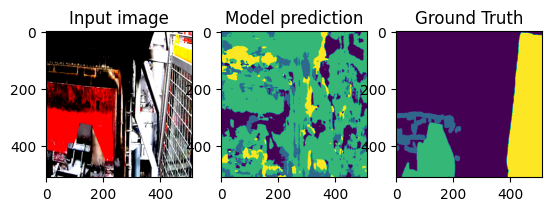

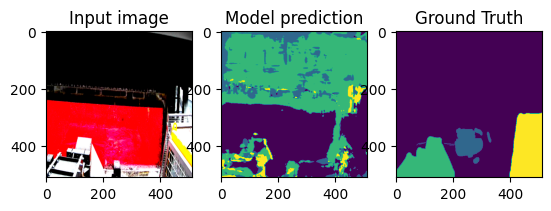

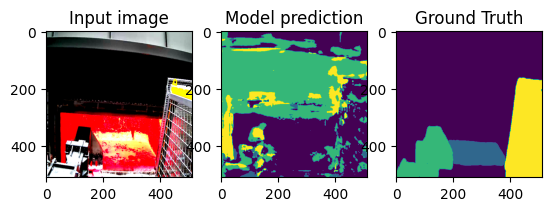

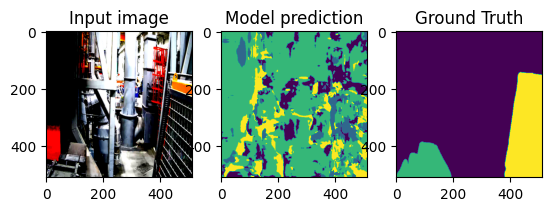

In [ ]:
for images, masks in train_set.take(4):
  inputs, targets = images, masks
  outs = model(inputs)
  outs = tf.argmax(outs, -1)

  for inp, out, target in zip(inputs, outs, targets):
      fig, ax = plt.subplots(1, 3)
      ax[0].imshow(inp.numpy())
      ax[1].imshow(out.numpy())
      ax[2].imshow(tf.argmax(target, -1).numpy())

      ax[0].set_title('Input image')
      ax[1].set_title('Model prediction')
      ax[2].set_title('Ground Truth')

In [ ]:
import time

In [ ]:
for i in test_set:
  start = time.time()
  preds = model(i[0])
  end = time.time()
  print(preds.shape)
  print(end - start)
  break

(4, 512, 512, 4)
0.7274124622344971
